In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from matplotlib.colors import ListedColormap
import matplotlib as mpl

In [2]:
# Part A. read and preprocessing data

In [3]:
# 1. read offence data from NZ Police
# data source: Stats NZ: http://archive.stats.govt.nz/Census/2013-census/data-tables/population-dwelling-tables/wellington.aspx#gsc.tab=0
# download the data as file 'data/wellington_police.csv'

# after downloading, read police data from csv

def read_police_data(path, encoding):
    df_columns = []
    df_values = []
    with open(path, encoding=encoding) as csvfile:
        reader = csv.reader(csvfile)
        
        for line in reader:
            line_str = ''.join(line)
            line_value = line_str.split('\t')
            if df_columns == []:
                df_columns = line_value
            else:
                df_values.append(line_value)
    df = pd.DataFrame(df_values, columns=df_columns)
    return df

df_police_raw = read_police_data("data/wellington_police.csv", "utf-16")

In [4]:
# 2. read population from Stats NZ
# data source: http://archive.stats.govt.nz/Census/2013-census/data-tables/meshblock-dataset.aspx#csv
# download the data as file 'data/wellington_population.xls'


def read_population_data(file_path, sheet_name):
    df_raw = pd.read_excel(file_path, sheet_name=3)
    df = pd.DataFrame([])
    df['area'] = df_raw.iloc[:, 1]
    df['pop2013'] = df_raw.iloc[:, 4]
    return df

df_population_raw = read_population_data('data/wellington_population.xls', 3)

In [5]:
# 3. data preprocessing
# 3.1 police data preprocessing

def count_offence(df_police_raw):
    df = pd.DataFrame([])
    s = df_police_raw['Area Unit'].value_counts().sort_index()
    df['offence'] = s.values
    df['area'] = s.index
    return df

def rename_area(df_police):
    df_police.index = df_police['area'].apply(lambda s: s.split('.')[0])
    df_police.index.name = 'area'
    df_police.drop(columns='area', inplace=True)
    return df_police

def police_pipe(df_police_raw):
    df_police = df_police_raw.copy()
    df_police = (df_police.pipe(count_offence)
                     .pipe(rename_area)
                    )
    return df_police

df_police = police_pipe(df_police_raw)

In [6]:
# 3.2 population data preprocessing

def get_area_population(df_population_raw):
    df = pd.DataFrame([])
    df['pop2013'] = pd.to_numeric(df_population_raw['pop2013'], errors='coerce')
    df['area'] = df_population_raw['area']
    df.dropna(inplace=True)
    df['area'] = df['area'].apply(lambda s: ' '.join(s.split(' ')[1:]))
    df.index = df['area']
    df.index.name = 'area'
    df.drop(columns='area', inplace=True)
    return df

df_population = get_area_population(df_population_raw)

In [7]:
# 3.3 combine based on area index

def wellington_area_crime_rates(df_police, df_population):
    index = df_police.index
    df_crime = pd.DataFrame([])
    df_crime['population'] = df_population.loc[df_police.index]['pop2013']
    df_crime['offence'] = df_police.loc[df_police.index]['offence']
    df_crime['rates'] = df_crime['offence']/df_crime['population']
    df_crime.index = index
    df_crime.index.name = 'area'
    return df_crime
df_crime = wellington_area_crime_rates(df_police, df_population)

In [8]:
# Part B. plot on map

# 1. read map data from Stats NZ
# Data Source:
# https://datafinder.stats.govt.nz/layer/25743-area-unit-2013/data/
# or you can find GIS data from openstreetmap

# download GIS data as shapely file to 'data/area_unit.shp'
# should include file 'area_unit.shx', 'area_unit.dbf', and 'area_unit.dbf' as well
df_map_raw = gpd.read_file('data/map/area_unit.shp')

In [9]:
df_map_raw.crs

<Projected CRS: EPSG:2193>
Name: NZGD2000 / New Zealand Transverse Mercator 2000
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: New Zealand - onshore
- bounds: (166.37, -47.33, 178.63, -34.1)
Coordinate Operation:
- name: New Zealand Transverse Mercator 2000
- method: Transverse Mercator
Datum: New Zealand Geodetic Datum 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [10]:
# 2. map data preprocessing

def preprocessing_df_map(df_map_raw, areas):
    df_map = gpd.GeoDataFrame([])
    df_map['geometry'] = df_map_raw['geometry']
    df_map.index = df_map_raw['AU2017_NAM']
    df_map = df_map.loc[areas]
    return df_map
    
areas = df_crime.index
df_map = preprocessing_df_map(df_map_raw, areas)

In [11]:
# 3. map data combine with police data and population data

def data_combining(df_map, df_crime):
    gdf = df_map
    gdf['offence'] = df_crime.loc[gdf.index]['offence']
    gdf['rates'] = df_crime.loc[gdf.index]['rates']
    return gdf

gdf = data_combining(df_map, df_crime)
gdf = gdf.to_crs(epsg=3857)

In [12]:
# 4. plot

In [13]:
# 4.1 custom cmap

colors = np.array([[245,245,245], [204, 231, 232], 
                      [93, 188, 210], [25, 121, 169], [25,25,112]])/256
cmap = ListedColormap(colors)

labels = ['lowest', 'second-lower', 'third-lower', 'second-highest', 'highest']

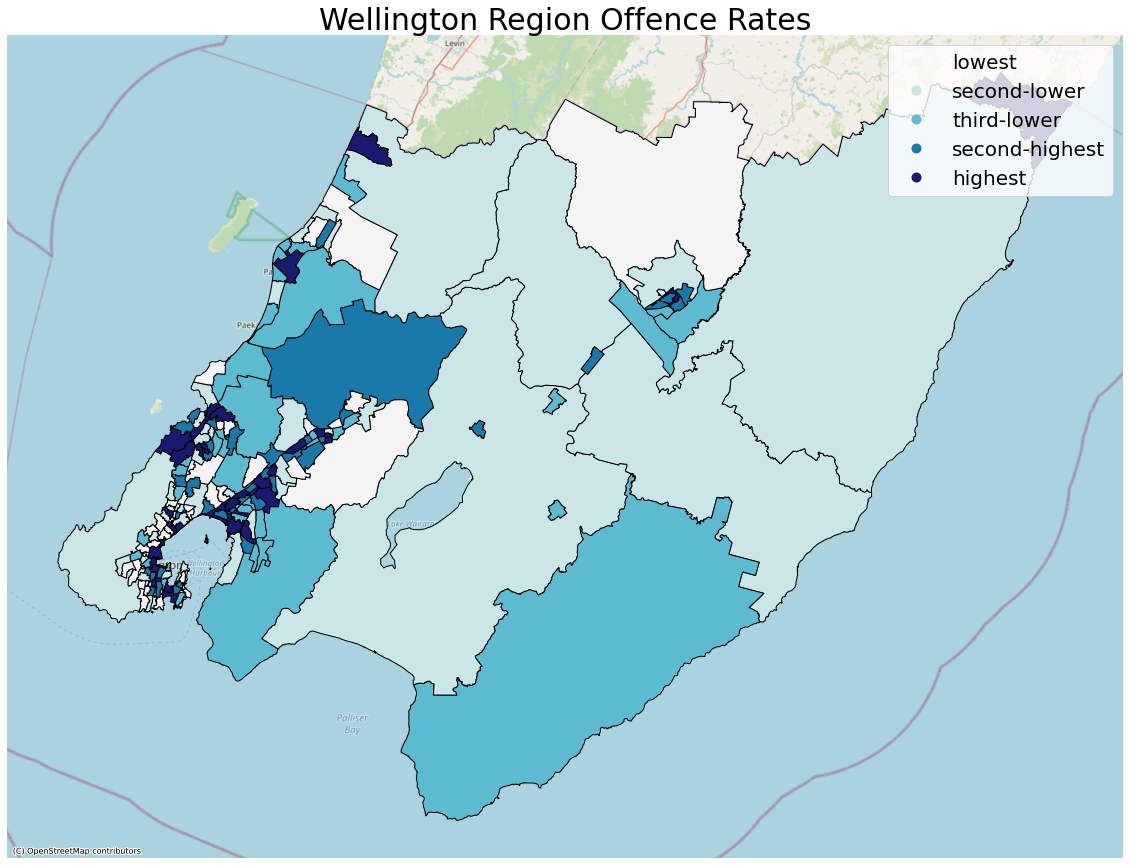

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

ax.set_title('Wellington Region Offence Rates', {'fontsize': 30})

gdf.plot(ax=ax, column='rates', cmap=cmap,
        scheme='quantiles', edgecolor='k', legend=True,
        legend_kwds={'labels': labels, 'fontsize': 20}
       );
ax.set_axis_off()
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)